# Variational Monte Carlo Using Steepest Descent for Arbitrary N Particles

In [6]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
from math import exp

from pdb import set_trace

## Monte Carlo Functions

In [8]:
# these are all the possible ground configurations that might
# contribute to the ground states

def get_random_state(num_particles):
    state = []
    positive_positions = random.sample(range(0, num_particles - 1), int(num_particles/2))
    for i in range(num_particles):
        if i in positive_positions:
            state.append(1)
        else:
            state.append(-1)
    return np.asarray(state)

In [9]:
def get_variational_projection(state, alpha):
    """
    This function computes the projection of state in the spin basis
    onto the varitional wave function
    """
    exponent = 0 
    # FOO DO WE COUNT THE SUMS TWICE?
    for i in range(len(state)):
        for j in range(len(state)):
            if i is not j:
                new_exp_term = (alpha/(min(abs(i-j),abs((i-len(state)) - j), abs(i - (j-len(state))))))*state[i]*state[j]/4 # need the "/4" because spin 1/2 particles
                exponent += new_exp_term
    return math.exp(exponent)

In [10]:
state = get_random_state(32)
get_variational_projection(state, 1)

0.004144227151239332

In [11]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()
    return state.copy()

In [12]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    # contribution from Z direction spin terms
    energy = 0
    state_proj = get_variational_projection(state, alpha)
    for i in range(len(state)):
        if i == len(state) - 1:
            energy += (state_proj*state[i] * state[0])/4
        else:
            energy += (state_proj*state[i] * state[i+1])/4
            
    # contributions from off diagonal terms
    non_diagonal_energies = 0
    off_diag_config_states = get_off_diagonal_configurations(state)
    for configuration in off_diag_config_states:
        non_diagonal_energies += (-0.5)*get_variational_projection(configuration, alpha)
    energy += non_diagonal_energies
    return energy / state_proj

In [13]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = get_variational_projection(trial_state, alpha) **2
    denominator = get_variational_projection(initial_state, alpha) **2
    return numerator / denominator

In [14]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_index] *= -1
            cont = False
    return state

In [29]:
def monte_carlo_estimation(alpha, num_steps, num_particles):
    # only works for even number of particles
    assert num_particles %2 == 0, "Number of particles must be even"

    x_initial = get_random_state(num_particles)
    running_total = 0
    for i in range(num_steps):
        clear_output(wait=True)
        print(f"Alpha: {alpha} -- Step: {i+1}/{num_steps}")
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        running_total += calculate_local_energy(x_initial, alpha)
    return running_total / num_steps

## Scan The Solution Space to find the Optimal Alpha and the Minimum Energy


In [30]:
# This function was derived analytically, and represents
# what we should expect out of the energy curve

def ground_truth_variational_energy(alpha):
    """
    with respect to alpha
    """
    numerator = -4*exp(-2*alpha) + -1*exp(-3*alpha)
    denominator = 2*exp(-1*alpha) + exp(-3*alpha)
    
    return numerator/denominator

In [31]:
def get_optimal_alpha(alphas, num_particles, num_steps=5000):
    energies = list()
    for i, alpha in enumerate(alphas):
        energies.append(monte_carlo_estimation(alpha, num_steps, num_particles))
    return alphas[np.argmin(energies)], np.argmin(energies), energies

In [32]:
alphas = [i*0.5 for i in range(-10,10)]; print(alphas)

[-5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]


## Test for 4 Particle System

In [34]:
## alphas = [i*0.05 for i in range(20,40)]
num_steps = 5000
num_particles = 4
alphas = [i*0.5 for i in range(-10,10)]
xs = np.asarray([i*0.1 for i in range(-5, 5)])
ys = np.asarray([ground_truth_variational_energy(x) for x in xs])

optimal_alpha, index, energies = get_optimal_alpha(alphas, num_particles, num_steps=num_steps)

plt.plot(xs, ys)
plt.plot(alphas, energies)
# plt.xlim(1,2)
plt.ylim()
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

Alpha: 4.5 -- Step: 4641/5000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

Optimal Alpha found at -0.5
Minimum Energy: -1.9777315191067935


## Run on 32 Particle System

In [ ]:
## alphas = [i*0.05 for i in range(20,40)]
num_steps = 5000
num_particles = 32
alphas = [i*0.5 for i in range(-10,10)]
xs = np.asarray([i*0.1 for i in range(-5, 5)])
ys = np.asarray([ground_truth_variational_energy(x) for x in xs])

optimal_alpha, index, energies = get_optimal_alpha(alphas, num_particles, num_steps=num_steps)

plt.plot(xs, ys)
plt.plot(alphas, energies)
# plt.xlim(1,2)
plt.ylim()
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

Alpha: -0.5 -- Step: 2785/5000


## Sorella's Derivative Estimation Function

In [18]:
def get_variational_gradient(local_energy, delta_star,
            ):
    """
    This function gets the variational energy gradient,
    where each element of the gradient corresponds to 
    the wave function derivative with respect to the
    indexed variational parameter
    Args:
    -
    """
    

In [ ]:
def generate_all_states(num_particles):
    """
    This function generates all the possible states of a system in which
    the total number of spin up particles equals the total number of
    spin down particles.
    """
    
    # this is a helper function that will be called recursively to generate
    # all states
    def generate_substates(head, remaining_1s, remaining_0s):
        if len(head) == num_particles:
            return [head]
        if not remaining_1s:
            return [np.append(head, np.zeros(num_particles - len(head)))]
        if not remaining_0s:
            return [np.append(head, np.ones(num_particles - len(head)))]
        branch0 = np.append(head, [0])
        branch1 = np.append(head, [1])
        states0 = generate_substates(branch0, remaining_1s, remaining_0s - 1)
        states1 = generate_substates(branch1, remaining_1s - 1, remaining_0s)
        return states0 + states1
    
    head = np.asarray([])
    return generate_substates(head, num_particles/2, num_particles/2)

In [ ]:
x = np.asarray([10])

In [ ]:
def calculate_expectation_OH(alpha, num_particles, all_states):
    
    

In [ ]:
def calculate_expectation_O(alpha, num_particles, all_states):
    """
    Ths function calculates the expectation value of <O> for an arbitrary numeber
    of particles, where O is the operator Sorella introduces and resides in the
    exponent of the variational wave functions projections.
    
    This function should only be called once, and saved in a variable to reduce
    computation time.
    """
    for state in all_states:
        for i in len(state):
            for j in len(state)
    
    return alpha * 

In [31]:
def find_optimal_alpha(lr = 0.03, num_steps =1000):
    """
    Note: only finds local minimums
    
    Algorithm will continue an additional 10 iterations
    after finding what it thinks is the optimal value
    """
    
    # cap the change in alpha
    d_alpha_cap = 0.3
    
    # get inital condition
    alphas = [] # list of all alphas that we test
    energies = [] # list of all energies corresponding to those alphas
    alpha = random.randint(-1000,1000)/100 # initial guess at alpha
    
    # pre loop conditions
    cont = True
    min_energy = 99999999999
    i = 0
    loop_count = 0
    plt.axis([0, 10, 0, 1])
    while(cont):
        clear_output(wait=True)
        # print(f"Loop Number: {loop_count} \nEnd Count: {i} \nAlpha: {alpha} \nMin Energy: {min_energy}")
        energy = monte_carlo_estimation(alpha, num_steps)
        derivative = get_variational_energy_derivative(energy, alpha)
        plt.plot(alphas, energies)
        plt.show()
        # update logs
        alphas.append(alpha)
        energies.append(energy)
        
        # if this energy is lowest, update optimal measurements,
        # and assume you can do better (set end count, i, to zero)
        if energy < min_energy:
                min_energy = energy
                opt_alpha = alpha
                i = 0
        # if not, inncrement the end count. If you don't get better
        # after 100 tries, it's probably time to stop
        else:
            i += 1
            if i == 400:
                cont = False
        # in case our derivative is close to zero
        if abs(lr*energy/derivative) > d_alpha_cap:
            derivative = lr*energy/d_alpha_cap
        
        try:
            alpha = alpha + lr*energy/derivative
        except ZeroDivisionError:
            alpha = alpha + lr*energy/(derivative+2)
            
        loop_count += 1
            
    print("Optimal Alpha: %3.2f" % opt_alpha)
    print("Optimal Energy: %3.2f" % min_energy)

    return opt_alpha, min_energy, alphas, energies

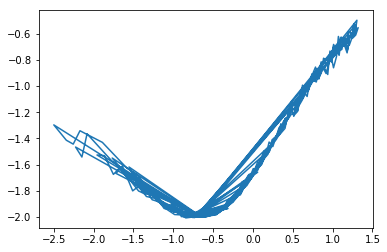

Optimal Alpha: -0.84
Optimal Energy: -2.01


In [33]:
opt_alpha, min_energy, alphas, energies = find_optimal_alpha()